# Imports

In [39]:
import pandas as pd
import numpy as np
from IPython import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import validation_curve  
from sklearn.pipeline import make_pipeline  
from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics as met
from IPython.display import Image
from tensorflow import keras
from keras.src.layers import Input, Dense, BatchNormalization
from keras import Model

# Eigen functies
Als je zelfgemaakte functies gebruikt in je antwoorden plaats de functie zelf dan in de cel hieronder

In [42]:
def lda_info(lda: LinearDiscriminantAnalysis, X, do_print: bool = False):
    """
    Return or print the info of the given LDA.
    :param lda: The linear discriminant analysis object.
    :param X: The list of independent objects of the lda.
    :param do_print: Print the output of the function instead of returning the output

    :returns dfs1: The prior probabilities of groups.
    :returns dfs2: The group means
    :returns dfs3: The coefficients of linear discriminants
    :returns dimensions: The dimensions of the lda
    """
    df1 = pd.DataFrame(lda.priors_, index=lda.classes_, columns=['prior probabilities'])
    df2 = pd.DataFrame(lda.means_, index=lda.classes_, columns=X.columns)
    df3 = pd.DataFrame(lda.scalings_, index=X.columns,
                       columns=['LD' + str(i + 1) for i in range(lda.scalings_.shape[1])])
    dfs1 = df1.style.set_caption('Prior probabilities of groups')
    dfs2 = df2.style.set_caption('Group means')
    dfs3 = df3.style.set_caption('Coefficients of linear discriminants')
    dimensions = min(X.columns.size, lda.classes_.size - 1)
    if do_print:
        display(dfs1)
        display(dfs2)
        display(dfs3)
        print(f'The LD has {dimensions} dimension(s)')
    return dfs1, dfs2, dfs3, dimensions

def polynomial_regression(degree=2, **kwargs):  
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression(**kwargs))  
    return model

def plot_roc(y_true, y_score, title='ROC Curve', **kwargs):
    if 'pos_label' in kwargs:
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score, pos_label=kwargs.get('pos_label'))
        auc = roc_auc_score(y_true, y_score)
    else:
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
        auc = roc_auc_score(y_true, y_score)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    figsize = kwargs.get('figsize', (7, 7))
    fix, ax = plt.subplots(1, 1, figsize=figsize)
    ax.grid(linestyle='--')

    ax.plot(fpr, tpr, color='darkorange', label='AUC: {}'.format(auc))
    ax.set_title(title)
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (FPR)')
    ax.fill_between(fpr, tpr, alpha=0.3, color='darkorange', edgecolor='black')

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.scatter(fpr[optimal_idx], tpr[optimal_idx],
               label='optimat cutoff {:.2f} op ({:.2f},{:.2f})'.format(optimal_threshold, fpr[optimal_idx],
                                                                       tpr[optimal_idx]), color='red')
    ax.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], linestyle='--', color='red')
    ax.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], linestyle='--', color='red')
    ax.legend(loc='lower right')
    plt.show()

# Vraag 1 (1 punt)

Iemand wil een LDA model maken om de *price_range* van een gsm te voorspellen. Hij gebruikt daarvoor 8 onafhankelijke variabelen. Hoeveel lineaire discriminant functies zal zijn model bevatten? *We vragen dus niet om een model te maken, maar enkel om het aantal lineaire discriminant functies te bepalen.*

## Antwoord

Hiervoor ga ik in de csv zien naar de price range in de csv. Ik zie dat de price range de volgende waarden bevat --> 0 1 2 3 (4 klassen) hiermee doe ik de volgende berekening:

K - 1 = 4 (klassen) - 1 = 3 lineaire discriminant functies bevatten

# Vraag 2
## a. (1 punt) 
Maak nu zelf een LDA model waarbij je op basis van *battery_power*, *clock_speed*, *fc*, *int_memory*, *n_cores*, *pc*, *ram* en *talk_time* tracht te voorspellen of de prijs van de gsm in de hoogste klasse zit. De afhankelijke variabele is dus niet gewoon price_range maar heeft als waarde True indien *price_range* == 3.

In [100]:
data = pd.read_csv('CellPhone_train.csv', sep=",")

data

,Unnamed: 0.1,Unnamed: 0,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,...,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,predicted_price_range,predicted_price_range_proba
0,0,0,842,0,2.2,0,1,0,7,0.6,...,2549,9,7,19,0,0,1,1,2,0.228768
1,1,1,1021,1,0.5,1,0,1,53,0.7,...,2631,17,3,7,1,1,0,2,2,0.219890
2,2,2,563,1,0.5,1,2,1,41,0.9,...,2603,11,2,9,1,1,0,2,2,0.245067
3,3,3,615,1,2.5,0,0,0,10,0.8,...,2769,16,8,11,1,0,0,2,2,0.177855
4,4,4,1821,1,1.2,0,13,1,44,0.6,...,1411,8,2,15,1,1,0,1,1,0.400540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1995,794,1,0.5,1,0,1,2,0.8,...,668,13,4,19,1,1,0,0,0,0.471320
1996,1996,1996,1965,1,2.6,1,0,0,39,0.2,...,2032,11,10,16,1,1,1,2,2,0.207789
1997,1997,1997,1911,0,0.9,1,1,1,36,0.7,...,3057,9,1,5,1,1,0,3,3,0.127551
1998,1998,1998,1512,0,0.9,0,4,1,46,0.1,...,869,18,10,19,1,1,1,0,0,0.360317


In [101]:
X = data[['battery_power', 'clock_speed', 'fc', 'int_memory', 'n_cores', 'pc', 'ram', 'talk_time']]

y = (data['price_range'] == 3).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)


In [102]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

### b. (1 punt)
Wat zijn de coëfficiënten van de eerste discriminant functie? 

In [111]:
# 3. LDA trainen op volledige dataset
lda = LinearDiscriminantAnalysis().fit(X, y)

# 4. Coëfficiënten van de eerste discriminantfunctie (LD1)
coef_ld1 = pd.Series(lda.scalings_[:, 0], index=X.columns)
print(coef_ld1)  # dit geeft exact dezelfde waarden als 'Coefficients of linear discriminants' in jouw helper

battery_power    0.000855
clock_speed     -0.015213
fc              -0.010454
int_memory       0.004280
n_cores         -0.001439
pc               0.003935
ram              0.001301
talk_time       -0.003131
dtype: float64


De coëfficiënten van de eerste LDA zijn:
- 0.000855
- -0.015213
- -0.015213
- -0.010454
- 0.004280
- -0.001439
- 0.003935
- 0.001301
- -0.003131

In [110]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 1. Data inlezen
data = pd.read_csv('CellPhone_train.csv', sep=',')

# 2. Features en binaire target
X = data[['battery_power','clock_speed','fc','int_memory',
          'n_cores','pc','ram','talk_time']]
y = (data['price_range']==3).astype(int)

# 3. LDA trainen op volledige dataset
lda = LinearDiscriminantAnalysis().fit(X, y)

# 4. Coëfficiënten van de eerste discriminantfunctie (LD1)
coef_ld1 = pd.Series(lda.scalings_[:, 0], index=X.columns)
print(coef_ld1)  # dit geeft exact dezelfde waarden als 'Coefficients of linear discriminants' in jouw helper

# 5. (optioneel) Helper functie aanroepen als je 'lda_info' al hebt uitgevoerd
# lda_info(lda, X, do_print=True)


battery_power    0.000855
clock_speed     -0.015213
fc              -0.010454
int_memory       0.004280
n_cores         -0.001439
pc               0.003935
ram              0.001301
talk_time       -0.003131
dtype: float64


# Vraag 3
In de kolom *predicted_price_range* vind je de voorspelde *price_range* waarden van een AI model (waarover we verder niet in detail gaan).

## a. (1,5 punten)
Bereken *precision*, *recall*, en *F1-score* voor elke klasse.

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

y = data['price_range'].astype(int)
y_pred_price = data['predicted_price_range'].astype(int)

prec = precision_score(y_true=y, y_pred=y_pred_price, average='weighted')
rec  = recall_score(   y_true=y, y_pred=y_pred_price, average='weighted')
f1   = f1_score(       y_true=y, y_pred=y_pred_price, average='weighted')

print(f"Precision = {prec:.3f}")
print(f"Recall    = {rec:.3f}")
print(f"F1-score  = {f1:.3f}")


Precision = 0.819
Recall    = 0.820
F1-score  = 0.819


- Precision:
    - 0: 0.90
    - 1: 0.76
    - 2: 0.74
    - 3: 0.87
- Recall:
    - 0: 0.92
    - 1: 0.76
    - 2: 0.72
    - 3: 0.88
- F1-score:
    - 0: 0.91
    - 1: 0.77
    - 2: 0.73
    - 3: 0.87

## b. (1,5 punten)
Voor welke klasse is het model het best in staat een voorspelling te doen? Op basis van welke informatie heb je dit beslist?

Voor klasse 0 en dit weet ik omdat zowel de prec, recall en f1 het hoogte liggen bij de metingen.

Precision = TP / (TP + FP): “Hoeveel van mijn positieve voorspellingen waren écht positief?”
Recall = TP / (TP + FN): “Hoeveel van de echte positieven heb ik gevonden?”
F1-score = 2 · (precision × recall) / (precision + recall): harmonische mean van precision en recall.

# Vraag 4

## a. (1 punt)
In een ander getraind AI-model hebben we onze focus gelegd op de gsm's in de middelste prijsklasse. We trachten in dit model te voorspellen of een gsm al dan niet in de prijsklasse 1 zit. De werkelijke waarde van de afhankelijke variabele is met andere woorden *price_range* == 1.

In de kolom *predicted_price_range_proba* vind je de voorspelde kansen dat een gsm in die middelste prijsklasse zit volgens het model.

Gebruik deze kolom om op basis van deze voorspelde kansen een ROC curve te tekenen. Wat is de AUC? 

de ROC‐curve laat je zien bij welke drempels je classifier een goede balans vindt tussen het vinden van positieve gevallen (TPR) en het vermijden van valse alarmen (FPR). De AUC geeft in één getal aan hoe goed dat in het algemeen lukt.

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

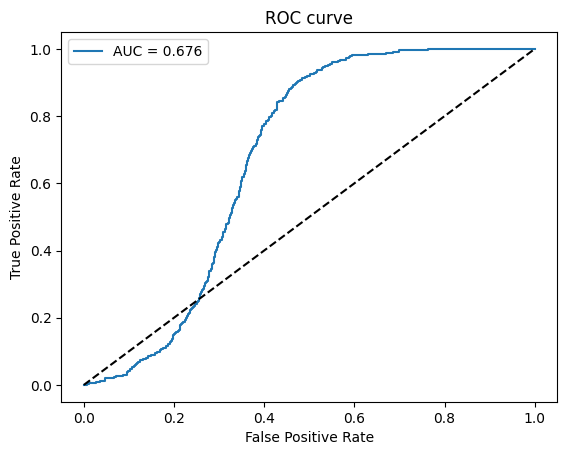

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true  = (data['price_range']==1).astype(int)
y_score = data['predicted_price_range_proba']

# 3) bereken FPR, TPR en AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_val = roc_auc_score(y_true, y_score)

# 4) plotten
plt.plot(fpr, tpr, label=f'AUC = {auc_val:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

## b. (1 punt)
Wat is het optimal cutoff point voor deze ROC curve? Wat wil dit zeggen? 

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

# stel y_true en y_score in zoals je al hebt
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# bereken J = TPR − FPR voor elke mogelijke drempel
j_scores = tpr - fpr

# vind de index van de maximale J
ix = np.argmax(j_scores)

optimal_threshold = thresholds[ix]
print(f'Optimal cutoff = {optimal_threshold:.3f}  (TPR={tpr[ix]:.3f}, FPR={fpr[ix]:.3f}, J={j_scores[ix]:.3f})')

Optimal cutoff = 0.205  (TPR=0.904, FPR=0.474, J=0.430)



# Vraag 5 (2 punten)
Op de afbeelding hiernaast zie je de resultaten van een getraind neuraal netwerk. In dit model worden geen biases/constante nodes gebruikt. Bij de outputlayer werd one-hot encoding toegepast.


## a.
Hoeveel inputvariabelen heeft dit netwerk?

### ANTWOORD
3 inputvariabelen

## b.
Hoeveel categorieën heeft de onafhankelijke (te voorspellen) variabele?

### ANTWOORD

Er zijn 2 outputvariabelen dus 2 categorieen.


## c.
Welke node uit de hidden layer heeft de grootste invloed op node 2 van de output layer? Geef de naam die boven de node staat.

### ANTWOORD

node H1 met een score van 3.1 tegenover H2 1.17

## d.
In de nodes zie je een schematische weergave van de activatiefunctie. Welke activatiefunctie wordt hier gebruikt?

In [96]:
import pandas as pd

# Maak een DataFrame met de meestvoorkomende activatiefuncties
# Gebruikte theorie: Activatiefuncties (linear, sigmoid, relu, etc.) uit de Neural Networks-slides

data = {
    "Functie": [
        "Linear", "Sigmoid", "ReLU", "Leaky ReLU", "Tanh", "ELU", "Softmax"
    ],
    "Formule": [
        "g(z) = z",
        "g(z) = 1 / (1 + exp(-z))",
        "g(z) = max(0, z)",
        "g(z) = z if z>0 else α·z  (α≈0.01)",
        "g(z) = (eᶻ - e⁻ᶻ) / (eᶻ + e⁻ᶻ)",
        "g(z) = z if z>0 else α·(eᶻ - 1)",
        "g_j(z) = exp(z_j) / Σ_k exp(z_k)"
    ],
    "Bereik": [
        "(-∞, ∞)",
        "(0, 1)",
        "[0, ∞)",
        "(-∞, ∞)",
        "(-1, 1)",
        "(-α, ∞)",
        "(0, 1), Σ=1"
    ],
    "Toepassing": [
        "Regressie output-layer",
        "Binaire classificatie",
        "Hidden-layers, efficiënt",
        "Hidden-layers, voorkomt dode neuronen",
        "Hidden-layers, gecentreerd rond 0",
        "Hidden-layers, zachte negatieve kant",
        "Multi-klasse output-layer"
    ]
}

df = pd.DataFrame(data)
print(df)


      Functie                             Formule       Bereik  \
0      Linear                            g(z) = z      (-∞, ∞)   
1     Sigmoid            g(z) = 1 / (1 + exp(-z))       (0, 1)   
2        ReLU                    g(z) = max(0, z)       [0, ∞)   
3  Leaky ReLU  g(z) = z if z>0 else α·z  (α≈0.01)      (-∞, ∞)   
4        Tanh      g(z) = (eᶻ - e⁻ᶻ) / (eᶻ + e⁻ᶻ)      (-1, 1)   
5         ELU     g(z) = z if z>0 else α·(eᶻ - 1)      (-α, ∞)   
6     Softmax    g_j(z) = exp(z_j) / Σ_k exp(z_k)  (0, 1), Σ=1   

                              Toepassing  
0                 Regressie output-layer  
1                  Binaire classificatie  
2               Hidden-layers, efficiënt  
3  Hidden-layers, voorkomt dode neuronen  
4      Hidden-layers, gecentreerd rond 0  
5   Hidden-layers, zachte negatieve kant  
6              Multi-klasse output-layer  


### ANTWOORD

de sigmoid logische functie hiervoor kijk ik naar de output (runn) hieronder voor uitleg over verschillende activatiefunties

# Vraag 6 (3 punten)
Train een neuraal netwerk met volgende specificaties:
* De inputlayer heeft een ode voor elk van de volgende variabelen:
    * *battery_power*
    * *clock_speed*
    * *fc*
    * *int_memory*
    * *n_cores*
    * *pc*
    * *ram*
    * *talk_time*
* De afhankelijke variabele (Y) is *price_range*
* Pas BatchNormalization toe op de inputlayer om de data te normaliseren.
* De (enige) hidden layer heeft 8 nodes en gebruikt de ReLU activatiefunctie.
* De outputlayer heeft 4 nodes voor elke categorie van *price_range* en gebruikt de softmax activatiefunctie.
* Gebruik ```model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.10), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])``` om het model te compileren.
* Train het model gedurende 10 epochs met een batch_size van 32 en een validation_split van 0.2. We moeten in de output kunnen zien dat het model getraind werd.

In [65]:
from tensorflow.keras.utils import to_categorical
from keras.src.layers import Input, Dense, BatchNormalization
from tensorflow.keras import Model  

x_data = data[['battery_power', 'clock_speed', 'fc', 'int_memory', 'n_cores', 'pc', 'ram', 'talk_time']]

y_data = data['price_range']

X_train, X_test, y_train, y_test = train_test_split(
    x_data,               # jouw dataframe met 8 features
    y_data,               # price_range (0–3)
    test_size=0.2,
    random_state=42,
    shuffle=True
)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape, y_test_one_hot.shape)

#dit is het aantal kolommen dat waar ik mee werk in de x_data 
inputs = Input(shape=(8,)) 
inputs = BatchNormalization()(inputs)
hidden = Dense(8, activation='relu')(inputs) # Hier geven we eerst de inputs die we zelf hebben gezet mee

total_output_neurons = pd.unique(y_data).size
outputs = Dense(total_output_neurons, activation='softmax')(inputs) # Bij de laatste kies je opnieuw de gewenste activation function en geef je de vorige output als input

model = Model(inputs, outputs, name='NN')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.10), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train_one_hot,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

(1600, 4) (400, 4)
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3764 - loss: 563.3707 - val_accuracy: 0.4156 - val_loss: 41.9235
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4129 - loss: 44.4056 - val_accuracy: 0.4844 - val_loss: 20.3490
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4458 - loss: 32.5967 - val_accuracy: 0.3688 - val_loss: 52.7253
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4643 - loss: 31.4914 - val_accuracy: 0.4625 - val_loss: 14.1667
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4608 - loss: 24.4242 - val_accuracy: 0.4812 - val_loss: 28.6679
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4468 - loss: 43.8553 - val_accuracy: 0.4469 - val_loss: 17.2049
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4974 - loss: 19.2656 - val_accuracy: 0.3750 - val_loss: 35.8043
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4770 - loss: 28.3119

# Vraag 7 (2 punten)
In de code onder de vraag zie je 10 chromosomen. Ook de doelfunctie waarvan we het resultaat willen maximaliseren is gegeven. Welke van deze oplossingen zal volgens het roulette selectiemechanisme het meeste kans maken om geselcteerd te worden voor mating/paring? Waarom?  

In [67]:
import math

x1 = [1.0, 0.5]
x2 = [-0.5, -0.5]
x3 = [1.0, 1.0]
x4 = [-0.75, -0.75]
x5 = [-0.5, 0.0]
x6 = [-0.5, -1.0]
x7 = [0.5, 0.5]
x8 = [0.5, 0.0]
x9 = [0.75, 0.75]
x10 = [-1.2, -1.0]


def energy(x):
    return ((0.2 + x[0] * x[0] + x[0] * x[1] - 0.1 * np.cos(1.0 * math.pi * x[0]) - 0.1 * np.cos(-2.0 * np.pi * x[1])))

In [71]:
energy(x1)
energy(x2)
energy(x3)
energy(x4)
energy(x5)
energy(x6)
energy(x7)
energy(x8)
energy(x9)
energy(x10)

1.9000000000000001

0.7999999999999999

2.2

1.3957106781186548

0.35

0.85

0.7999999999999999

0.35

1.3957106781186548

2.8209016994374947

## Antwoord

x10 heeft de meeste kans om geselecteerd te worden voor pairing omdat hij de hoogste energy heeft 2.8209016994374947

# Vraag 8 (2 punten)
In de code bij vraag 8 vind je een dataframe. Deze bevat de scores van de doelfunctie voor een generatie chromosomen. Het optimalisatieprobleem is een minimalisatieprobleem. Voor de selectie van de chromosomen die mogen paren/maten wordt het tournament selectie mechanisme gebruikt.

Voor de eerste selecteren chromosoom werd in de eerste stap van het selectie-algoritme chromosomen 1, 3, 6, 8 en 20 geselecteerd. Welke van deze chromosomen zal in aanmerking komen voor 'mating/paring'? Met andere woorden wat is het resultaat van deze selecte-operatie? Waarom?

In [72]:
populatie = pd.DataFrame({'chromosoon': range(1, 21),
                          'score_doelfunctie': [247.6251629, 214.51757898, 249.13309669, 188.81888775, 104.80883904,
                                                316.12006777, 198.56246032, 465.06055288, 156.80288596, 243.7813792,
                                                185.9045345, 146.50208061, 119.45574293, 364.05258658, 416.80157775,
                                                481.66470259, 412.22107183, 421.06760396, 227.18712982, 229.35077602]})
populatie

,chromosoon,score_doelfunctie
0,1,247.625163
1,2,214.517579
2,3,249.133097
3,4,188.818888
4,5,104.808839
5,6,316.120068
6,7,198.562460
7,8,465.060553
8,9,156.802886
9,10,243.781379


#ANTWOORD

Van de selected chromosonen op basis van het minimalisatieprobleem zal tussen de chromosonen 1, 3, 6, 8 en 20 zal 20 winnnen met zijn waarde van 229.35 heeft die de laagste.

Wát er wordt gedaan:
Je neemt een klein “toernooi” (hier: chromosomen 1, 3, 6, 8 en 20) en kiest daaruit één winnaar om door te mogen naar de paringspool.
Hoe die winnaar wordt bepaald:
Omdat het probleem een minimalisatie is, wint het chromosoom met de laagste doelfunctiescore.
Wat het resultaat is voor dit toernooi:
– Chromosoom 1 → score 247.63
– Chromosoom 3 → score 249.13
– Chromosoom 6 → score 316.12
– Chromosoom 8 → score 465.06
– Chromosoom 20 → score 229.35
De laagste score is 229.35, dus chromosoom 20 wordt geselecteerd.


# Vraag 9 
Onder vraag 9 zie je de code voor het oplossen van een Sudoku met simulated annealing. Je krijgt een startbestand en het is de bedoeling de nullen te vervangen door de cijfers 1 tot en met 9. Bij het oplossen hou je rekening met volgende Sudoku contraints:
- In elke rij de getallen 1 tot en met 9 exact 1 keer voorkomen.
- In elke kolom de getallen 1 tot en met 9 exact 1 keer voorkomen.
*In een echte Sudoku is je veld ook verdeeld in 9 blokken van 3\*3. In elk blok moet elk getal van 1 tot en met 9 exact 1 keer voorkomen. Deze laatste regel implementeren we niet voor deze heuristiek.*

Bij deze heuristiek lees je eerst een startSituatie van een sudoku in waarbij de in te vullen waarbij de in te vullen waarden gelijk zijn aan 0 (zie csv). Het grootste deel van de code is al uitgewerkt.

- Cel 1: StartSituatie inlezen > leest de sudoku in. Hierin pas je niet aan.
- Cel 2: emptyfields aanmaken > maakt een lijst van de indices van de lege velden. Hierin pas je niets aan.
- Cel 3: Simulated annealing klasse > bevat de klasse Sudoku die de simulated annealing uitvoert.

In [86]:
#CEL 1: Startsituatie inlezen (NIETS AANPASSEN)
## 
from simanneal import Annealer

board = pd.read_csv('sudoku.csv', header=None)

#CEL 2: emptyfields aanmaken (NIETS AANPASSEN)
# Code om de indexen van de lege velden in een list te steken [Niet aanpassen]
board_emptyFields = board == 0
emptyfields = np.where(board_emptyFields.to_numpy().flatten() == True)[
    0].tolist()  #De indices van de lege velden (velden met nul)

## a. (2 punten)
Werk in Cel 3 de move functie uit. Je weight bij een move slechts één willekeurig veld van de Sudoku naar een andere waarde. Enkel velden die nog niet zijn ingevuld waren bij de startSituatie (waarde = 0) mogen gewijzigd worden. (tip: emptyfields bevat de indices van de lege velden)

In [94]:
#CEL 3: Simulated annealing klasse
class Sudoku(Annealer):
    # ENGERGY FUNCTIE NIET AANPASSEN
    def energy(self):
        s = pd.DataFrame(self.state.reshape(9, 9))
        lineTotal = 45
        lineSums = pd.concat([s.sum(axis=1), s.sum(axis=0)])  #Telt de som van de inhoud van de rijen en de kolommen 
        valueCounts = pd.Series(np.unique(s, return_counts=True))[
            1]  #Telt hoe vaak elk getal voorkomt in een rij of kolom
        valueCountErrorCost = np.absolute(valueCounts - 9).sum() * 10
        lineValueErrorCost = np.absolute(lineSums - lineTotal).sum() * 2
        return valueCountErrorCost + lineValueErrorCost
    
#ANTWOORD
    def move(self):
        """
        Maakt een willekeurige zet door één leeg veld te veranderen naar een andere waarde.
        Alleen velden die leeg waren in de startSituatie (waarde 0) mogen worden gewijzigd.
        """
        import random
        
        # Kies willekeurig een leeg veld uit emptyFields
        if len(emptyfields) == 0:
            return  # Geen lege velden om te wijzigen
        
        # Selecteer willekeurig een positie uit de lege velden
        random_index = random.randint(0, len(emptyfields) - 1)
        linear_index = emptyfields[random_index]  # Dit is een enkele integer
        
        # Converteer de lineaire index naar row, col coordinaten
        # Voor een 9x9 sudoku: row = index // 9, col = index % 9
        row = linear_index // 9
        col = linear_index % 9
        
        # Kies een nieuwe waarde (1-9) die verschilt van de huidige waarde
        current_value = self.state[row, col]
        possible_values = [i for i in range(1, 10) if i != current_value]
        
        if possible_values:
            new_value = random.choice(possible_values)
            self.state[row, col] = new_value

## b. (1 punt)
Voer de heuristiek uit door de 4 cellen na elkaar uit te voeren.

In [95]:
probleem = Sudoku(np.array(board))
probleem.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


     2.50000         44.00     0.00%     0.00%     0:00:18     0:00:00

(array([[5, 9, 2, 4, 7, 1, 7, 4, 7],
        [5, 5, 4, 8, 7, 2, 5, 1, 9],
        [6, 9, 1, 3, 4, 6, 1, 9, 8],
        [3, 2, 3, 7, 2, 9, 3, 6, 9],
        [4, 5, 9, 3, 5, 7, 4, 5, 3],
        [1, 2, 6, 6, 3, 5, 8, 9, 3],
        [8, 2, 8, 7, 1, 5, 4, 8, 2],
        [6, 8, 8, 1, 9, 3, 6, 4, 1],
        [7, 4, 2, 6, 6, 7, 8, 1, 2]]),
 36)